COPYRIGHT © 2018 Kiran Arun <kironni@gmail.com>

### Setup

In [1]:
# get dependencies
!rm -r Reinforcement_Learning-101-demo/
!git clone https://github.com/KiranArun/Reinforcement_Learning-101-demo.git
from google.colab import auth
auth.authenticate_user()
!chmod +x Reinforcement_Learning-101-demo/scripts/setup.sh
!./Reinforcement_Learning-101-demo/scripts/setup.sh

Cloning into 'Reinforcement_Learning-101-demo'...
remote: Counting objects: 145, done.
remote: Compressing objects: 100% (109/109), done.
remote: Total 145 (delta 79), reused 87 (delta 35), pack-reused 0
Receiving objects: 100% (145/145), 5.26 MiB | 22.44 MiB/s, done.
Resolving deltas: 100% (79/79), done.
Getting files from drive
Updating...


Installing cmake...


Installing ffmpeg...


Installing gym...
Installing opencv...


In [2]:
# run tensorboard
get_ipython().system_raw('tensorboard --logdir=/content/logdir/ --host=0.0.0.0 --port=6006 &')
get_ipython().system_raw('/content/ngrok http 6006 &')
!curl -s http://localhost:4040/api/tunnels | python3 -c "import sys, json; print('Tensorboard Link:', json.load(sys.stdin)['tunnels'][0]['public_url'])"

Tensorboard Link: http://9893decd.ngrok.io


# Reinforcement Learning

This is the second part to the reinforcement learning workshop.

In this notebook we will learn what A3C is, and how the model is trained.

#### Notebook information:
- this notebook will train an A3C model and save checkpoints and logs for tensorboard
- it will also go through what A3C is, and how it works in our case
- the code is based off https://github.com/awjuliani/DeepRL-Agents/blob/master/A3C-Doom.ipynb
- I also recommend the blog post corresponding to his code [Simple Reinforcement Learning with Tensorflow Part 8: Asynchronous Actor-Critic Agents (A3C)](https://medium.com/emergent-future/simple-reinforcement-learning-with-tensorflow-part-8-asynchronous-actor-critic-agents-a3c-c88f72a5e9f2)

### Asynchronous Advantage Actor-Critic (A3C)

Asynchronous: Working along side each other but not in time

Advantage: How good or bad actions were in terms of the relative returns

Actor: The part calculating the probabilities for each action

Critic: The part calculating the values for the state

![A3C diagram](imgs/A3C_diagram.jpg)

### High Level Overview:

1. Create our master/global network
2. Create our worker/local networks
3. Set workers to work:
    - update local network
    - interact with environment using predicted actions for a few steps
    - calculate gradient using the most recent experiences
    - update global network
    - if episode is over:
        - calculate gradient using the most recent experiences
        - update global network
        - restart

### Importing Libraries

In [0]:
import numpy as np                 # our linear algebra library
import matplotlib.pyplot as plt    # our plotting library
import tensorflow as tf            # our machine learning library

import gym                         # the environment library
import cv2                         # our image processing library
import scipy.signal                # to discount our rewards over time
import threading                   # to run multiple workers at the same time

import time,os,sys
from IPython.display import HTML   # to show videos

import A3C_helper_functions as helper # helper functions

### Settings and Hyperparameters

**gamma:** discount value, for time step $t$, the reward $k$ steps in the future, $d(r_{t+k})=\gamma^kr_{t+k}$

**state_size:** the input frame size (the image will be unstacked into a vector)

**num_actions:** number of possible actions in environment

**max_episodes:** number of episodes any worker needs to reach for training to stop (you can also stop it manually whenever)

**learning_rate:** learning rate

**num_workers:** number of worker networks

**start_checkpoint:** You canset it to whatever model checkpoint you want (with the same network and num_workers). the model will start training from here instead of from scratch.

In [0]:
gamma = .99           # discount value over time
state_size = 84**2    # the size of our input image (unstacked)
num_actions = 6       # the number of possible actions to take in environment

max_episodes = 10000  # how many episodes for the first worker to reach to stop training
learning_rate = 2e-4  # learning rate
num_workers = 16      # number of workers
tmax = 50             # the number of time steps until an update is made
max_grad_norm = 40    # maximum gradient norm

# set directories
model_root_dir = '/content/'
model_logdir = os.path.join(model_root_dir,'logdir/')

# model checkpoint to start training from
# set to None if training from scratch
start_checkpoint = None

# our optimizer
trainer = tf.train.AdamOptimizer(learning_rate=learning_rate, epsilon=1e-2)

get the name for this specific training run (so it can be searched on tensorboard)

In [0]:
# get name of the log directory
run_logdir = helper.get_logdir(model_logdir,learning_rate,num_workers,tmax)

### Discount function

The further in the future the reward is, the less we want it to contribute to updating the current action.

$discount(x,\gamma)_t = \sum_{k=0}\gamma^tx_{t+k}$

In [0]:
# discounting function used to calculate current + discounted future returns
def discount(x, gamma):
    return(scipy.signal.lfilter([1], [1, -gamma], x[::-1], axis=0)[::-1])

### Update worker function

This will set the variables from the worker/local network to the master/global networks variables.

In [0]:
# update worker from global network
def update_worker_network(from_scope, to_scope):
    from_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, from_scope)
    to_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, to_scope)
    ops_holder = []
    for from_var,to_var in zip(from_vars,to_vars):
        ops_holder.append(to_var.assign(from_var))
    return(ops_holder)

### The Network

**Inputs:** the input frame(s) (state)
- we input the frames unstacked into 1 vector per image
- we then put the images back into their image shape
- None is the batch size but we only feed 1 frame per forward pass in inference

**Conv net:** 2 convolutional layers
- this is to analyse the image

**Fully Connected:** a single fully connected layer
- this is to finnish analysing the image

**LSTM:** a Long Short Term Memory cell
- we input the output of fc1 and the lstm state
- the lstm cell will output an updated lstm state every forward pass, and we'll pass that in next step
- this will allow the neural net to make a decision based on not just the current input, but the history (the state)
- this goes for all recurrent neural networks (lstm's are a subcatagory)

**Policy:** the fully connected output layer
- we use a final fully connected layer to out 6 probabilities
- the probability represents how good its corresponding action is
- we use softmax activation to convert raw outputs to probabilities

**Value:** another fully connected output layer
- this will predict the value of the current state
- this is the same as all future rewards summed together

### Updating the Network

We will update the global network using the gradient from the local networks.

#### Loss functions:

**Value loss:** the difference between predicted total, discounted rewards, and true total, discounted rewards.
- The target values are $TV_t = v_{t+K}+\sum_{k=0}^K\gamma^kr_{t+k}$
- with $v_t =$ the predicted value for time step $t$
- $L = \frac{1}{2}\sum_{t=0}^T(TV_t - v_t)^2$

**Policy loss:** this will use the values and true rewards to change the policy to bias towards better actions
- advantages = difference in reward between the true actions taken, and the actions with the highest probability given the current policy (the value)
- the advantage > 0, if reward is greater than value
- the advantage < 0, if reward is lower than value
- when the advantage > 0, the action probabilities will be driven up to decrease the loss
    - this means the rewards for the route taken were better than the rewards for the route our model would choose
    - and so the probabilities for the route taken should be higher
- when the advantage < 0, the action probabilities will be driven down to decrease the loss
    - this means the rewards for the route taken were worse than the rewards for the route our model would choose
    - and so the probabilities for the route taken should be lower
- with $a_t =$ action probability at step $t$ and $d_t =$ advantage as step $t$
- $-\sum_{t=0}^T\ln(a_t)d_t$
    
**Entropy:** this will increase as more of the mass of the action mass function (policy) goes on to one action
- this makes the action probabilities more even, increasing exploration
- with $P_t =$ policy outputs for timestep $t$ (action probabilities)
- $- \sum_{t=0}^T P_t\ln(P_t)$

In [0]:
class AC_Network():
    def __init__(self, state_size, num_actions, scope, trainer):
        with tf.variable_scope(scope):
            
            # Inputs
            self.inputs = tf.placeholder(shape=[None, state_size], dtype=tf.float32)
            self.inputs_reshaped = tf.reshape(self.inputs, shape=[-1, 84, 84, 1])
            
            # Conv net - image analysis
            self.conv1 = tf.layers.conv2d(inputs=self.inputs_reshaped,
                                          filters=16,
                                          kernel_size=[8, 8],
                                          strides=[4, 4],
                                          activation=tf.nn.elu,
                                          padding='SAME')
            self.conv2 = tf.layers.conv2d(inputs=self.conv1,
                                          filters=32,
                                          kernel_size=[4, 4],
                                          strides=[2, 2],
                                          activation=tf.nn.elu,
                                          padding='SAME')
            
            # Fully connected - image analysis
            self.fc1 = tf.layers.dense(inputs=tf.layers.flatten(self.conv2),
                                       units=256,
                                       activation=tf.nn.elu)

            # LSTM - include information about the history in the predictions
            lstm_state_size = 256
            lstm_cell = tf.contrib.rnn.BasicLSTMCell(num_units=lstm_state_size, state_is_tuple=True)
            
            # create initial state
            self.initial_state = (np.zeros([1,lstm_state_size]),np.zeros([1,lstm_state_size]))
            
            # create state placeholders
            c_input_state = tf.placeholder(shape=[1,lstm_state_size], dtype=tf.float32)
            h_input_state = tf.placeholder(shape=[1,lstm_state_size], dtype=tf.float32)
            self.input_state = tf.nn.rnn_cell.LSTMStateTuple(c_input_state,h_input_state)
            
            # reformat input data [batch_size, time_steps, features]
            # our batch size is always 1
            rnn_in = tf.expand_dims(self.fc1, [0])
            
            # define lstm
            lstm_outputs, self.lstm_state = tf.nn.dynamic_rnn(cell=lstm_cell,
                                                              inputs=rnn_in,
                                                              initial_state=self.input_state,
                                                             )
            
            # reshape the outputs so that shape = [time_steps, lstm_state_size]
            # our batch size is always 1, so we can remove it
            rnn_out = tf.reshape(lstm_outputs, [-1, lstm_state_size])
            
                        
            # Policy - probabilities of each action
            self.policy = tf.layers.dense(inputs=rnn_out,
                                          units=num_actions,
                                          activation=tf.nn.softmax,
                                          bias_initializer=None)
            
            # Value - total discounted reward given current policy
            self.value = tf.layers.dense(inputs=rnn_out,
                                         units=1,
                                         activation=None,
                                         bias_initializer=None)
            
            
            
            # for all worker networks
            # this will update the global network using the current workers gradients
            if scope != 'global':
              
              
                
                # actions placeholder
                self.actions = tf.placeholder(shape=[None], dtype=tf.int32)
                self.actions_onehot = tf.one_hot(self.actions, num_actions, dtype=tf.float32)
                # the reward of current step + future rewards discounted
                self.target_values = tf.placeholder(shape=[None], dtype=tf.float32)
                # difference in reward for current and future steps discounted
                self.advantages = tf.placeholder(shape=[None], dtype=tf.float32)
                
                # get probability values of actions
                self.responsible_outputs = tf.reduce_sum(self.policy * self.actions_onehot, [1])
                
                

                # Loss functions
                
                # Value loss - difference between predicted and true rewards
                self.value_loss = 0.5 * tf.reduce_sum(tf.square(self.target_values - tf.reshape(self.value, [-1])))
                
                # Policy loss -  how good were the rewards compared to what rewards if the actions were taken from the policy
                self.policy_loss = -tf.reduce_sum(tf.log(self.responsible_outputs) * self.advantages)
                
                # Entropy - to make policy values more uniform to increase exploration
                self.entropy = - tf.reduce_sum(self.policy * tf.log(self.policy))
                
                # combine losses
                self.loss = 0.5 * self.value_loss + self.policy_loss - self.entropy * 0.01
                
                

                # get local variables
                local_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope)
                # calculate gradients of loss in terms of local variables
                self.gradients = tf.gradients(self.loss, local_vars)
                # clip gradients when norm > 50
                # this reduces the values so the norm = 50
                grads, self.grad_norms = tf.clip_by_global_norm(self.gradients, max_grad_norm)

                # get global variables and perform backpropagation on them
                global_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 'global')
                self.apply_grads = trainer.apply_gradients(zip(grads,global_vars))

### Workers

In the work function, it will:

repeat:
- **UPDATE LOCAL VARS:** set the local variables to the global variables
- **RESET AND INITIATE THINGS:** reset and initiate environment, episode history/buffer and lstm state

- repeat:
    - **GET ACTION:** feed state in to neural net and get policy as output (action probabilities)
    - **PERFORM ACTION:**, choosing the action from the action probabilitiy distibution (the policy)
    - **SAVE TO BUFFER:** record the input state, action, reward, new state and predicted value to history
    - **TRAIN:** if buffer length = tmax, call train function
        - **TARGET REWARDS:** for time step $t$ = total discounted rewards from after and including $t$
        - $TV_t = v_{t+K}+\sum_{k=0}^K\gamma^kr_{t+k}$
        - **ADVANTAGES:** advantage for time step $t$ = total discounted (reward for step $t$ - predicted reward for step $t$)  from after and including $t$
        - $A_t = \sum_{k=0}^K \gamma^k(r_{t+k} - (v_{t+k} - \gamma v_{t+k+1}))$
        - **APPLY UPDATE:** update global network using apply grads from above
        - **UPDATE LOCAL VARS:** set the local variables to the global variables
        
- until episode has finnished
- **TRAIN:**
    - **APPLY UPDATE:** update global network using apply grads from above

until max episodes reached

In [0]:
class Worker():
    def __init__(self, worker_number, state_size, num_actions, trainer, max_episodes):
        
        # set up worker
        self.worker_name = "worker_" + str(worker_number)
        self.number = worker_number
        self.trainer = trainer
        self.max_episodes = max_episodes
        self.episodes_history = np.empty([0,2])
        
        # create a writer for current worker to save episode steps and reward
        self.writer = tf.summary.FileWriter(run_logdir+'/'+self.worker_name)
        
        # create worker network
        self.local_AC = AC_Network(state_size, num_actions, self.worker_name, trainer)
        # get operations to update local network from global network
        self.update_local_ops = update_worker_network('global', self.worker_name)
        
        # create local environment
        self.env = gym.make('SpaceInvaders-v4')
        
    # function to update global network with workers experience and gradients
    def train(self, rollout, sess, gamma, bootstrap_value):
        
        # seperate history from worker experience buffer (rollout)
        rollout = np.array(rollout)
        observations = rollout[:,0]
        actions = rollout[:,1]
        rewards = rollout[:,2]
        next_observations = rollout[:,3]
        values = rollout[:,5]
        
        # TARGET REWARDS
        # add predicted value to end of rewards
        # this is called bootstrapping
        # we are combining the networks output and rewards recieved to improve the network
        rewards_with_bootstrap = np.asarray(rewards.tolist() + [bootstrap_value])
        # total rewards over time discounted
        discounted_rewards = discount(rewards_with_bootstrap,gamma)[:-1]
        
        # ADVANTAGES
        # add predicted value to end of predicted values
        values_with_bootstrap = np.asarray(values.tolist() + [bootstrap_value])
        # reward recieved - reward predicted for time step t
        advantages = rewards + gamma * values_with_bootstrap[1:] - values_with_bootstrap[:-1]
        # discounted and summed over time
        advantages = discount(advantages, gamma)
        
        # create feed dict
        feed_dict = {self.local_AC.target_values:discounted_rewards,
                     self.local_AC.inputs:np.vstack(observations),
                     self.local_AC.actions:actions,
                     self.local_AC.advantages:advantages,
                     self.local_AC.input_state[0]:self.batch_lstm_states[0],
                     self.local_AC.input_state[1]:self.batch_lstm_states[1]}
        
        # APPLY UPDATE
        # run training step to apply gradients to global network
        self.batch_lstm_states,_ = sess.run([self.local_AC.lstm_state,
                                             self.local_AC.apply_grads],
                                            feed_dict=feed_dict)
        
    # function to run a worker during training
    def work(self, gamma, sess, coord, saver):
        
        # initiate current number of episodes worker has done
        worker_episode_count = 0
        print ("Starting " + str(self.worker_name))
        with sess.as_default(), sess.graph.as_default():
            # when coordinator hasn't been requested to stop
            # start an episode
            while not coord.should_stop():
                
                
                # UPDATE LOCAL VARS
                sess.run(self.update_local_ops)
                
                
                # RESET AND INITIATE THINGS
                
                # initiate buffer and done
                episode_buffer = []
                d = False
                # initiate history to hold episode stats (for analysis)
                episode_history = []
                
                # Reset environment
                init_frame = self.env.reset()
                # process frame
                processed_s = helper.preprocess_frame(init_frame).reshape(1,-1)
                # set input frame
                s = processed_s
                
                # Reset lstm state
                self.current_lstm_states = self.local_AC.initial_state
                self.batch_lstm_states = self.local_AC.initial_state
                
                # if not done
                while d == False:
                    
                    # GET ACTION
                    # get policy, values and new rnn state
                    a_dist, v, self.current_lstm_states = sess.run([self.local_AC.policy,
                                                                    self.local_AC.value,
                                                                    self.local_AC.lstm_state],
                                                                   feed_dict={self.local_AC.inputs:s,
                                                                              self.local_AC.input_state[0]:self.current_lstm_states[0],
                                                                              self.local_AC.input_state[1]:self.current_lstm_states[1]})
                    
                    # PERFORM ACTION
                    # get chosen action from policy action probabilities
                    a = np.random.choice(a_dist[0],p=a_dist[0])
                    a = np.argmax(a_dist == a)
                    # take step in environment
                    unprocessed_s1, r, d, info = self.env.step(a)
                    
                    # process new frame
                    if d == False:
                        processed_s1 = helper.preprocess_frame(unprocessed_s1).reshape(1,-1)
                        # get maximum of current and previous frames
                        s1 = np.maximum(processed_s,processed_s1)
                    else:
                        s1 = s
                       
                    # SAVE TO BUFFER
                    # add to episode buffer and episode values
                    episode_buffer.append([s, a, r, s1, d, v[0,0]])
                    
                    # update new values
                    episode_history += [[s, a, r, s1, d]]
                    s = s1
                    processed_s = processed_s1
                    
                    # TRAIN
                    # when buffer is full but episode hasn't ended
                    if len(episode_buffer) == tmax and d != True:
                        
                        # get current value prediction to use as future rewards
                        v1 = sess.run(self.local_AC.value,
                                      feed_dict={self.local_AC.inputs:s,
                                                 self.local_AC.input_state[0]:self.current_lstm_states[0],
                                                 self.local_AC.input_state[1]:self.current_lstm_states[1]})[0,0]
                        
                        # run train function to update global network with local gradients
                        self.train(episode_buffer, sess, gamma, v1)
                        
                        # reset local buffer
                        episode_buffer = []
                        
                        # UPDATE LOCAL VARS
                        sess.run(self.update_local_ops)
                    
                    # when episode has finished
                    if d == True:
                        break
                    
                # TRAIN
                # update global network for the last step in episode with remaining buffer
                if len(episode_buffer) != 0:
                    self.train(episode_buffer, sess, gamma, 0.0)
                
                # helper function to save episode stats to tensorboard
                self.episodes_history,worker_episode_count = helper.end_training_episode(episode_history,
                                                                                         self.episodes_history,
                                                                                         worker_episode_count,
                                                                                         self.worker_name,
                                                                                         saver,
                                                                                         sess,
                                                                                         run_logdir,
                                                                                         self.writer)
                
                # when the first worker reaches max episodes, request a stop
                if worker_episode_count == self.max_episodes:
                    print('stopping training,', self.worker_name, 'has reached episode', worker_episode_count)
                    coord.request_stop()

In [0]:
# reset tensorflow graph
tf.reset_default_graph()

### Creating global network and workers

In [0]:
# create global network
master_network = AC_Network(state_size, num_actions, 'global', None)
    
workers = []
# create list of workers
for i in range(num_workers):
    workers.append(Worker(i, state_size, num_actions, trainer, max_episodes))

# define summary writer for main graph
main_writer = tf.summary.FileWriter(run_logdir+'/main')

### Initailizing things

- Create Tensorflow Session
- Create Tensorflow coordinator to handle the threads
- Create Tensorflow saver to save open/save checkpoints
- Restore model checkpoint if set to do so
- Write the session to tensorboard

In [0]:
# setup tensorflow
sess = tf.InteractiveSession()               # session

coord = tf.train.Coordinator()               # coordinator for threads
saver = tf.train.Saver(max_to_keep=None)     # model saver

sess.run(tf.global_variables_initializer())  # initialize variables

if start_checkpoint != None:
    saver.restore(sess, start_checkpoint)    # choose starting checkpoint
    
main_writer.add_graph(sess.graph)            # write graph to tensorboard

### Training

- Start workers
- Every few minutes, play a test game with global network and log to tensorboard
- Save model after training has finnished

In [13]:
worker_threads = []
tests = np.empty([0,2])

# start workers
for worker in workers:
    worker_work = lambda: worker.work(gamma, sess, coord, saver)
    t = threading.Thread(target=(worker_work))
    t.start()
    worker_threads.append(t)
    time.sleep(0.5)

# start tests with master network
n = 0
while coord.should_stop() != True:
    tests = np.append(tests, np.array(helper.test(sess,master_network)).reshape(1,2),axis=0)
    summary = tf.Summary()
    summary.value.add(tag='test_episode_steps',simple_value=int(tests[-1,0]))
    summary.value.add(tag='test_episode_reward',simple_value=int(tests[-1,1]))
    main_writer.add_summary(summary, n)
    main_writer.flush()
    n += 1
    time.sleep(180)
    
# stop and save when threads have all stopped
coord.join(worker_threads)
print('Saving final model...')
saver.save(sess, os.path.join(run_logdir, "final_model.ckpt"))

Starting worker_0
Starting worker_1
Starting worker_2
Starting worker_3
Starting worker_4
Starting worker_5
Starting worker_6
Starting worker_7
Starting worker_8
Starting worker_9
Starting worker_10
Starting worker_11
Starting worker_12
Starting worker_13
Starting worker_14
Starting worker_15
worker_11 :  episode: 0 reward: 80.0 actions: [15. 29.  8. 12.  6. 29.]
worker_5 :  episode: 0 reward: 75.0 actions: [15. 28. 11. 11.  6. 29.]
worker_7 :  episode: 0 reward: 30.0 actions: [15. 32. 11. 11.  7. 25.]
worker_4 :  episode: 0 reward: 105.0 actions: [13. 28. 13. 11.  7. 28.]
worker_1 :  episode: 0 reward: 145.0 actions: [16. 26.  8. 12.  8. 30.]
worker_6 :  episode: 0 reward: 355.0 actions: [16. 28. 11. 12.  5. 28.]
worker_0 :  episode: 0 reward: 180.0 actions: [13. 25. 10. 13.  7. 31.]
worker_9 :  episode: 0 reward: 120.0 actions: [18. 24. 12. 12.  7. 27.]
worker_2 :  episode: 0 reward: 155.0 actions: [14. 26. 11. 11.  8. 30.]
worker_13 :  episode: 0 reward: 150.0 actions: [16. 26. 12. 

KeyboardInterrupt: ignored

If you stopped training before letting it finnish, this will:
- check for final saved model
- if it doesnt exist:
    - stop threads
    - save final model

In [14]:
# if stopped before it saves and stops threads, do this
if os.path.exists(os.path.join(run_logdir,"final_model.ckpt.index")) != True:
  coord.request_stop()
  coord.join(worker_threads)
  print('Saving final model...')
  saver.save(sess, os.path.join(run_logdir, "final_model.ckpt"))

worker_15 :  episode: 0 reward: 295.0 actions: [18. 22. 17. 10. 10. 23.]
Saving final model...
INFO:tensorflow:/content/logdir/run_02-lr_0.0002-nw_16-tmax_50/final_model.ckpt is not in all_model_checkpoint_paths. Manually adding it.


### Play and display test game

360 framesSteps: 366 Reward: 50.0


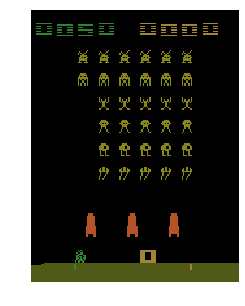

In [15]:
# test game
frames = helper.display_test(sess,master_network)
anim = helper.create_gameplay_video(frames,figsize=(5,5),save=False)
HTML(anim.to_jshtml())